# No Ruido

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, SparsePauliOp, state_fidelity
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import EfficientSU2
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error 
from qiskit.primitives import StatevectorEstimator as Estimator

J = 1.0
g = 0.5

hamiltonian = SparsePauliOp.from_list([
    ("ZZ", -J),
    ("XI", -g),
    ("IX", -g)
])

n_qubits = 2
n_layers = 1

ansatz = EfficientSU2(n_qubits, su2_gates=["rx", "ry"], reps=n_layers, entanglement="full")
params = ParameterVector("theta", ansatz.num_parameters)

estimator = Estimator()

cost_hist_noruido = []
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
    cost_hist_noruido.append(cost)
    return cost

x0 = np.ones(ansatz.num_parameters)
res = minimize(cost_func_vqe, x0, args=(ansatz, hamiltonian, estimator), method="COBYLA")
energia_minima = res.fun


C:\Users\galel\AppData\Local\Temp\ipykernel_16876\3273287698.py:25: DeprecationWarning: The class ``qiskit.circuit.library.n_local.efficient_su2.EfficientSU2`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.efficient_su2 instead.
  ansatz = EfficientSU2(n_qubits, su2_gates=["rx", "ry"], reps=n_layers, entanglement="full")


# Ruido

In [114]:
import numpy as np
import matplotlib.pyplot as plt 
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2
from qiskit.circuit import ParameterVector, QuantumCircuit
from scipy.optimize import minimize

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.result import Counts


J = 1.0
g = 0.5

hamiltonian = SparsePauliOp.from_list([
    ("ZZ", -J),
    ("XI", -g),
    ("IX", -g)
])

exact_ground_state_energy = -np.sqrt(2) 

n_qubits = 2
n_layers = 1

ansatz = EfficientSU2(n_qubits, su2_gates=["rx", "ry"], reps=n_layers, entanglement="full")
params = ParameterVector("theta", ansatz.num_parameters) 

def calculate_pauli_expectation_value(counts: Counts, pauli_string_label: str, num_qubits: int) -> float:
    """Calculates the expectation value of a Pauli string from measurement counts."""
    exp_val = 0.0
    total_shots = sum(counts.values())

    pauli_qubits_affected = []
    for i, char in enumerate(pauli_string_label):
        if char != 'I':
            pauli_qubits_affected.append(i)

    for outcome, count in counts.items():
        reversed_outcome = outcome[::-1] 
        current_parity = 1
        for q_idx in pauli_qubits_affected:
            if reversed_outcome[q_idx] == '1':
                current_parity *= -1
        
        exp_val += current_parity * count
    
    if total_shots == 0:
        return 0.0
    return exp_val / total_shots


def cost_func_vqe_noisy(params_array, ansatz_template, hamiltonian_obj, simulator, shots):
    assigned_ansatz = ansatz_template.assign_parameters(params_array)
    decomposed_ansatz = assigned_ansatz.decompose() 
    
    total_energy = 0.0
    for pauli_op, coeff in zip(hamiltonian_obj.paulis, hamiltonian_obj.coeffs):
        pauli_string_label = pauli_op.to_label()
        
        measurement_circuit = QuantumCircuit(ansatz_template.num_qubits, ansatz_template.num_qubits)
        measurement_circuit.compose(decomposed_ansatz, inplace=True)

        for i, pauli_char in enumerate(pauli_string_label):
            if pauli_char == 'X':
                measurement_circuit.h(i)
            elif pauli_char == 'Y':
                measurement_circuit.sdg(i) 
                measurement_circuit.h(i)  
        
        measurement_circuit.measure(range(ansatz_template.num_qubits), range(ansatz_template.num_qubits))

        job = simulator.run(measurement_circuit, shots=shots, seed_simulator=42) 
        result = job.result()
        counts = result.get_counts(measurement_circuit) 
        
        pauli_exp_val = calculate_pauli_expectation_value(counts, pauli_string_label, ansatz_template.num_qubits)
        
        total_energy += coeff.real * pauli_exp_val 
    
    return total_energy


error_probability = 0.01 
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(error_probability, 1), ['rx', 'ry'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(error_probability, 2), ['cx'])

noisy_simulator = AerSimulator(noise_model=noise_model)
shots = 2048 

ruido_cost_hist = []
def cost_func_vqe_noisy_wrapper(params_array_opt):
    cost = cost_func_vqe_noisy(params_array_opt, ansatz, hamiltonian, noisy_simulator, shots=shots)
    ruido_cost_hist.append(cost) 
    return cost

x0_noisy = np.ones(ansatz.num_parameters) 
res_noisy = minimize(cost_func_vqe_noisy_wrapper, x0_noisy, args=(), method="COBYLA") 
energia_minima_ruido = res_noisy.fun

C:\Users\galel\AppData\Local\Temp\ipykernel_16876\3798737484.py:27: DeprecationWarning: The class ``qiskit.circuit.library.n_local.efficient_su2.EfficientSU2`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.efficient_su2 instead.
  ansatz = EfficientSU2(n_qubits, su2_gates=["rx", "ry"], reps=n_layers, entanglement="full")


# Computadora IBM

In [ ]:
#Con ayuda de Gemini para lograr que funcionara

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit import transpile

from qiskit_ibm_runtime import QiskitRuntimeService, Estimator as RuntimeEstimator
from qiskit_ibm_runtime.exceptions import IBMRuntimeError

J = 1.0
g = 0.5

hamiltonian = SparsePauliOp.from_list([
    ("ZZ", -J),
    ("XI", -g),
    ("IX", -g)
])

exact_ground_state_energy = -np.sqrt(2)
print(f"Theoretical Exact Ground State Energy: {exact_ground_state_energy:.6f}\n")

n_qubits = 2
n_layers = 1

ansatz = EfficientSU2(n_qubits, su2_gates=["rx", "ry"], reps=n_layers, entanglement="full")
params = ParameterVector("theta", ansatz.num_parameters)

print("--- Setting up IBM Quantum Runtime Service ---")

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='69be880ddbc69dea944dc2c21ba36595a9845cc284be9fd50e4c60996a3c3c5e823707cb6e1fddc1a4a9ba6fa6b0f9875ff9014ddb62ab936b51951522764327'
)

selected_backend_name = None
backend_obj_for_transpile = None

print("\n--- Listing available backends in your instance ---")
available_backends = service.backends(instance='ibm-q/open/main')
if not available_backends:
    print("No backends found in the specified instance. Please check your 'instance' string and account access.")
else:
    for backend in available_backends:
        status_info = "UNKNOWN"
        if hasattr(backend, 'status') and callable(backend.status):
            try:
                status_info = backend.status().status.name
            except Exception:
                status_info = "ERROR_RETRIEVING"
        print(f"- Name: {backend.name}, N_qubits: {backend.num_qubits}, Simulator: {backend.simulator}, Status: {status_info}")
print("--------------------------------------------------\n")

try:
    backend_obj_for_transpile = service.least_busy(
        simulator=False,
        min_num_qubits=n_qubits,
        instance='ibm-q/open/main'
    )
    selected_backend_name = backend_obj_for_transpile.name
    print(f"Selected least busy real backend: {selected_backend_name}")

except IBMRuntimeError as e:
    print(f"Could not find a suitable real backend: {e}.")
    print("Attempting to fall back to an available simulator within your 'ibm-q/open/main' instance.")
    
    found_simulator = False
    for b in service.backends(simulator=True, instance='ibm-q/open/main'):
        if b.num_qubits >= n_qubits:
            backend_obj_for_transpile = b
            selected_backend_name = b.name
            found_simulator = True
            print(f"Selected fallback simulator: {selected_backend_name}")
            break
    
    if not found_simulator:
        print("\n--- ERROR: No suitable backend (real device or simulator) found in your 'ibm-q/open/main' instance. ---")
        print("Please review the 'Listing available backends' section above to find a valid backend name.")
        raise RuntimeError("Failed to select any IBM Quantum backend. Cannot proceed with VQE.")

print(f"DEBUG: Backend selected for Runtime Estimator: '{selected_backend_name}'")
if selected_backend_name is None or selected_backend_name == "":
    raise ValueError("Internal Error: selected_backend_name is empty or None after selection logic. This should not happen.")

estimator = RuntimeEstimator(mode=backend_obj_for_transpile)

print(f"\n--- Diagnostic: Type of Estimator initialized: {type(estimator)} ---")
print("If the type above is NOT '<class 'qiskit_ibm_runtime.primitives.estimator.Estimator'>',")
print("or if you still encounter a TypeError related to 'service' or 'backend' here,")
print("you MUST follow the 'TROUBLESHOOTING YOUR QISKIT ENVIRONMENT' steps below.\n")


cost_hist = []
def cost_func_vqe(params_array, ansatz_template, hamiltonian_obj, estimator_obj, transpile_backend_obj, target_backend_name):
    assigned_ansatz = ansatz_template.assign_parameters(params_array)
    
    transpiled_circuit = transpile(assigned_ansatz.decompose(), transpile_backend_obj, optimization_level=3)
    
    isa_hamiltonian = hamiltonian_obj.apply_layout(layout=transpiled_circuit.layout)
    
    pub = (transpiled_circuit, isa_hamiltonian, [])
    
    job = estimator_obj.run([pub])
    
    cost = job.result()[0].data.evs
    
    cost_hist.append(cost)
    return cost

print("\n--- Running VQE Optimization on IBM Quantum ---")

x0 = np.ones(ansatz.num_parameters)

def cost_func_vqe_wrapper(params_array_opt):
    return cost_func_vqe(params_array_opt, ansatz, hamiltonian, estimator, backend_obj_for_transpile, selected_backend_name)

res = minimize(cost_func_vqe_wrapper, x0, args=(), method="COBYLA")
energia_minima = res.fun

print(f"Estimated ground state energy (VQE on IBM Quantum): {energia_minima:.6f}")
print(f"Difference from theoretical exact: {abs(exact_ground_state_energy - energia_minima):.6f}")

opt_params = res.x
vqe_circuit = ansatz.assign_parameters(opt_params)
vqe_circuit = vqe_circuit.decompose()

plt.figure(figsize=(8, 5))
plt.plot(cost_hist, label='VQE IBM Quantum', marker='o', linestyle='-', color='purple')
plt.axhline(y=exact_ground_state_energy, color='gray', linestyle='-.', label=f'Exact Energy ({exact_ground_state_energy:.3f})')
plt.axhline(y=energia_minima, color='purple', linestyle=':', alpha=0.7, label=f'IBM Quantum VQE Min ({energia_minima:.3f})')
plt.title('VQE Convergence on IBM Quantum')
plt.xlabel('Optimization Iteration')
plt.ylabel('Energy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#Los datos obtenidos se guardaron de forma externa

# Comparando las tres

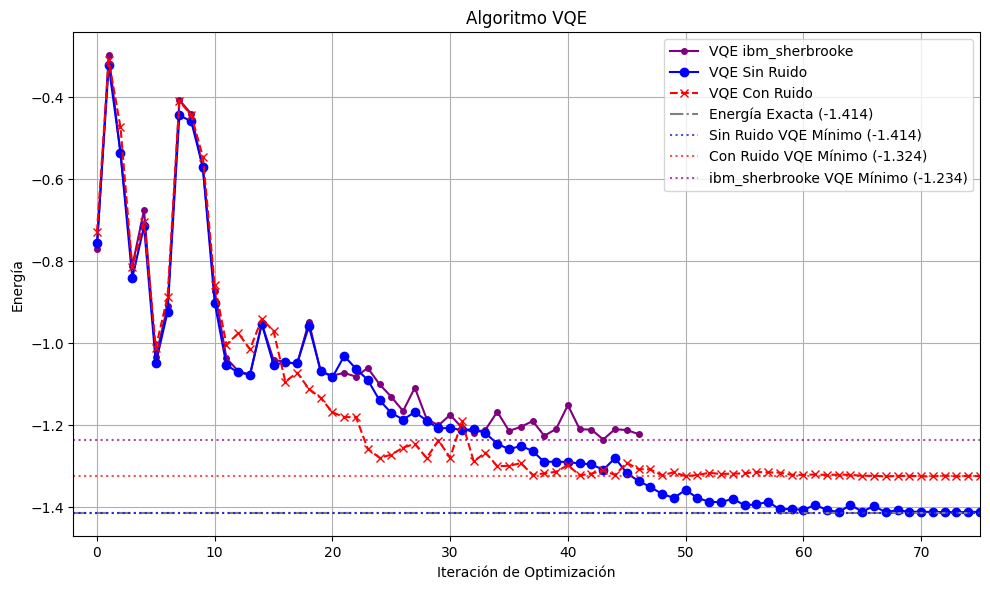

In [115]:
import matplotlib.pyplot as plt
import numpy as np

cost_hist = [
    -0.7704904268522451, -0.2975696275805458, -0.5372265816704299,
    -0.8119815630444759, -0.6748753928048823, -1.0323655191382084,
    -0.9091356861748032, -0.406667405483882, -0.44021839875430996,
    -0.575075693724863, -0.8722122277520655, -1.0366293812965086,
    -1.0672259208319799, -1.076421311729589, -0.9514895037857932,
    -1.0402751826065324, -1.045161254623273, -1.0503967960459555,
    -0.9475695488210598, -1.0693077824798656, -1.0782722277473513,
    -1.0720258716960585, -1.0809855903133514, -1.0598274412741284,
    -1.0996836807328345, -1.1302623529658782, -1.1647793048510764,
    -1.1080803638388492, -1.1839609913629063, -1.1999774156874115,
    -1.1740525482271076, -1.2057258949477758, -1.2174137110828922,
    -1.210311369268149, -1.1666802019411977, -1.2132878131182905,
    -1.203648234902056, -1.1893194983293474, -1.2252450813366669,
    -1.2083937379418854, -1.150536836413565, -1.2092281855061293,
    -1.2102587952583748, -1.2343033687397644, -1.2090563369164078,
    -1.2113664601939407, -1.2210044493016021
]


energia_minima_ibm = min(cost_hist)

energia_minima_vqe = -1.414214
energia_minima_noisy = -1.2

plt.figure(figsize=(10, 6))
plt.xlim(-2, 75)  

plt.plot(cost_hist, label='VQE ibm_sherbrooke', marker='o', linestyle='-', color='purple', markersize=4)

plt.plot(cost_hist_noruido, label='VQE Sin Ruido', marker='o', linestyle='-', color='blue')
plt.plot(ruido_cost_hist, label='VQE Con Ruido', marker='x', linestyle='--', color='red')

plt.axhline(y=eigenvalor_exacto, color='gray', linestyle='-.', label=f'Energía Exacta ({eigenvalor_exacto:.3f})')
plt.axhline(y=energia_minima, color='blue', linestyle=':', alpha=0.7, label=f'Sin Ruido VQE Mínimo ({energia_minima:.3f})')
plt.axhline(y=energia_minima_ruido, color='red', linestyle=':', alpha=0.7, label=f'Con Ruido VQE Mínimo ({energia_minima_ruido:.3f})')
plt.axhline(y=energia_minima_ibm, color='purple', linestyle=':', alpha=0.7, label=f'ibm_sherbrooke VQE Mínimo ({energia_minima_ibm:.3f})')

plt.title('Algoritmo VQE')
plt.xlabel('Iteración de Optimización')
plt.ylabel('Energía')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
